## bayesian model pmod

In [157]:
import os
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip
import nilearn.plotting

In [ ]:
# Meyniel toolbox
# !git clone https://github.com/florentmeyniel/TransitionProbModel.git

In [2]:
# !ls /model

In [2]:
import sys, os
sys.path.append('/model')
from MarkovModel_Python import IdealObserver as IO
from MarkovModel_Python import GenerateSequence as sg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings

### set up

In [3]:
experiment_dir = '/output'
output_dir = 'prob_pmod'
working_dir = 'workingdir'
TR = 2.

### sepcify nodes

In [4]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

### helper functions dev

In [5]:
alltrialinfo = pd.read_csv('/tsl_data/data/fmri_behavioural.csv')
alltrialinfo.head()

,subject,session,trial,seq,rt,gen_p1g2,gen_p2g1,prob_pxl,prob_obs,obs_p1g2,obs_p2g1,obs_p1g1,obs_p2g2,obs_p1,obs_p2,obs_p,runtime
0,6,1,1,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.60
1,6,1,2,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.10
2,6,1,3,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.60
3,6,1,4,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.05
4,6,1,5,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.60


In [6]:
def construct_sj(trialinfo, subject_id, run_num, cond_name=None):
    # construct df
    df_sj = trialinfo[(trialinfo['subject']==int(subject_id)) & (trialinfo['session']==int(run_num))]
    sj_info = pd.DataFrame()
    sj_info['onset'] = df_sj['runtime']
    sj_info['duration'] = 0.
    sj_info['weight'] = 1.
    trial_type = df_sj['seq'].replace({1:'Low', 2:'High'})
    sj_info['trial_type'] = trial_type
    if cond_name:
        sj_info_cond = sj_info[sj_info['trial_type']==cond_name]
    else:
        sj_info_cond = sj_info
    return sj_info_cond

In [7]:
construct_sj(alltrialinfo, '06', '1')

,onset,duration,weight,trial_type
0,1.60,0.0,1.0,High
1,3.10,0.0,1.0,High
2,4.60,0.0,1.0,High
3,6.05,0.0,1.0,High
4,7.60,0.0,1.0,High
...,...,...,...,...
255,469.05,0.0,1.0,High
256,470.45,0.0,1.0,Low
257,471.85,0.0,1.0,High
258,473.40,0.0,1.0,Low


In [8]:
# preparing data for modelling
def unpack(df):
    """extract sequence and ratings"""
    seq = df['seq'].values - 1 # convert to toolbox format 1->0 low, 2->1 high
    rate_idx = {}
    rate_idx['p1g1'] = df['obs_p1g1'].notnull()
    rate_idx['p1g2'] = df['obs_p1g2'].notnull()
    rate_idx['p2g2'] = df['obs_p2g2'].notnull()
    rate_idx['p2g1'] = df['obs_p2g1'].notnull()
    rate_obs = df['obs_p']
    return seq, rate_idx, rate_obs

def fit(df, model='fixed', order=0, options={'decay':5}):
    """fit given sequence"""
    seq, rate_idx, rate_p = unpack(df)
    model_p = np.empty(seq.shape)
    model_p.fill(np.nan)
    gen_p = np.empty(seq.shape).fill(np.nan)
    out = IO.IdealObserver(seq, model, order=order, 
                           options=options)
    if order == 0:
        p0 = out[(0,)]['mean'] # equivalent to 1
        p1 = out[(1,)]['mean'] # equivalent to 2
        # recording output
        model_p[rate_idx['p1g2']] = p0[rate_idx['p1g2']]
        model_p[rate_idx['p2g1']] = p1[rate_idx['p2g1']]
        model_full = pd.DataFrame({'p0':p0, 'p1':p1, 'surprise':out['surprise']}, index=None)
    elif order == 1:
        p01 = out[(1,0)]['mean'] # p(0|1)
        p10 = out[(0,1)]['mean'] # p(1|0)
        p11 = out[(1,1)]['mean'] # p(1|1)
        p00 = out[(0,0)]['mean'] # p(0|0)
        # record output
        # print(p01[-10:])
        # print(p10[-10:])
        model_p[rate_idx['p1g2']] = p01[rate_idx['p1g2']]
        model_p[rate_idx['p2g1']] = p10[rate_idx['p2g1']]
        model_full = pd.DataFrame({'p01':p01, 'p10':p10, 'surprise':out['surprise']}, index=None)

    return model_p, rate_p, model_full

def model_df(df, model='fixed', order=0, options={'decay':5}, dropna=True):
    """create hierarchical model df"""
    model_p, rate_p, model_full = fit(df, model, order, options)
    df['model_p'] = model_p
    df['rate_p'] = rate_p
    df_out = pd.concat([df.reset_index(), model_full], axis=1)
    if dropna:
        df_out.dropna(subset=['model_p'], inplace=True)
    return df_out

def model_subject(trialinfo, subject_id, run_num, model, order, options, dropna=False):
    """apply model and extract subject/run"""
    dfm = model_df(trialinfo, model=model, order=int(order), options=options, dropna=dropna)
    df_sj = dfm[(dfm['subject']==int(subject_id)) & (dfm['session']==int(run_num))]
    return df_sj

In [9]:
dfmm = model_subject(alltrialinfo, subject_id='06', run_num=1, 
              model='hmm', order=0, options={'p_c':0.05, 'resol':20}, 
              dropna=False)

In [19]:
# dfmm['p1'].values.tolist()

### specify GLM

In [131]:
def subjectinfo(subject_id):

    import pandas as pd
    import numpy as np
    import sys, os
    sys.path.append('/model')
    from MarkovModel_Python import IdealObserver as IO
    from MarkovModel_Python import GenerateSequence as sg
    from nipype.interfaces.base import Bunch
    
    def construct_sj(trialinfo, subject_id, run_num, cond_name=None):
        # construct df
        df_sj = trialinfo[(trialinfo['subject']==int(subject_id)) & (trialinfo['session']==int(run_num))]
        sj_info = pd.DataFrame()
        sj_info['onset'] = df_sj['runtime']
        sj_info['duration'] = 0.
        sj_info['weight'] = 1.
        trial_type = df_sj['seq'].replace({1:'Low', 2:'High'})
        sj_info['trial_type'] = trial_type
        if cond_name:
            sj_info_cond = sj_info[sj_info['trial_type']==cond_name]
        else:
            sj_info_cond = sj_info
        return sj_info_cond

    def select_confounds(subject_id, run_num, conf_names):
        """select confounds for regressor"""
        confounds_dir = f'/data/sub-%02d/func/' % int(subject_id)
        confounds_file = confounds_dir+f'sub-%02d_task-tsl_run-%d_desc-confounds_regressors.tsv' % (int(subject_id), int(run_num))
        conf_df = pd.read_csv(confounds_file, sep='\t')
        conf_select = conf_df[conf_names].loc[4:].fillna(0)
        conf_select_list = [conf_select[col].values.tolist() for col in conf_select] # ignore first 4 dummy scans
        return conf_select_list
    
    # preparing data for modelling
    def unpack(df):
        """extract sequence and ratings"""
        seq = df['seq'].values - 1 # convert to toolbox format 1->0 low, 2->1 high
        rate_idx = {}
        rate_idx['p1g1'] = df['obs_p1g1'].notnull()
        rate_idx['p1g2'] = df['obs_p1g2'].notnull()
        rate_idx['p2g2'] = df['obs_p2g2'].notnull()
        rate_idx['p2g1'] = df['obs_p2g1'].notnull()
        rate_obs = df['obs_p']
        return seq, rate_idx, rate_obs

    def fit(df, model='fixed', order=0, options={'decay':5}):
        """fit given sequence"""
        seq, rate_idx, rate_p = unpack(df)
        model_p = np.empty(seq.shape)
        model_p.fill(np.nan)
        gen_p = np.empty(seq.shape).fill(np.nan)
        out = IO.IdealObserver(seq, model, order=order, 
                               options=options)
        if order == 0:
            p0 = out[(0,)]['mean'] # equivalent to 1
            p1 = out[(1,)]['mean'] # equivalent to 2
            # recording output
            model_p[rate_idx['p1g2']] = p0[rate_idx['p1g2']]
            model_p[rate_idx['p2g1']] = p1[rate_idx['p2g1']]
            model_full = pd.DataFrame({'p0':p0, 'p1':p1, 'surprise':out['surprise']}, index=None)
        elif order == 1:
            p01 = out[(1,0)]['mean'] # p(0|1)
            p10 = out[(0,1)]['mean'] # p(1|0)
            p11 = out[(1,1)]['mean'] # p(1|1)
            p00 = out[(0,0)]['mean'] # p(0|0)
            # record output
            # print(p01[-10:])
            # print(p10[-10:])
            model_p[rate_idx['p1g2']] = p01[rate_idx['p1g2']]
            model_p[rate_idx['p2g1']] = p10[rate_idx['p2g1']]
            model_full = pd.DataFrame({'p01':p01, 'p10':p10, 'surprise':out['surprise']}, index=None)

        return model_p, rate_p, model_full

#     def model_df(df, model='fixed', order=0, options={'decay':5}, dropna=True):
#         """create hierarchical model df"""
#         model_p, rate_p, model_full = fit(df, model, order, options)
#         df['model_p'] = model_p
#         df['rate_p'] = rate_p
#         df_out = pd.concat([df.reset_index(), model_full], axis=1)
#         if dropna:
#             df_out.dropna(subset=['model_p'], inplace=True)
#         return df_out

#     def model_subject(trialinfo, subject_id, run_num, model, order, options, dropna=False):
#         """apply model and extract subject/run"""
#         dfm = model_df(trialinfo, model=model, order=int(order), options=options, dropna=dropna)
#         df_sj = dfm[(dfm['subject']==int(subject_id)) & (dfm['session']==int(run_num))]
#         return df_sj

    def find_runs(subject_id):
        """find available runs from func"""
        from glob import glob
    #     func_dir = f'/output/smooth/preproc/sub-%02d/' % int(subject_id)
        func_dir = f'/output/smooth_nomask/preproc/sub-%02d/' % int(subject_id)    
        func_files = glob(func_dir+'*bold.nii')
        runs = []
        for f in func_files:
            tmp = f.split('/')
            run = tmp[5].split('_')[2].split('-')[1]
            runs.append(int(run))
        return sorted(runs)
    
    conf_names = ['csf','white_matter','global_signal',
    'std_dvars','dvars', 'framewise_displacement', 'rmsd',
    'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
    'a_comp_cor_04', 'a_comp_cor_05', 
    'trans_x', 'trans_y', 'trans_z', 'rot_x','rot_y','rot_z']
#     't_comp_cor_00', 't_comp_cor_01', 't_comp_cor_02',
                      #'motion_outlier00', 'motion_outlier01','motion_outlier02', 'motion_outlier03']

    alltrialinfo = pd.read_csv('/tsl_data/data/fmri_behavioural.csv')
    alltrialinfo.head()
    
    subject_info = []
    onset_list = []
    condition_names = ['Stim']
    runs = find_runs(subject_id)
    print(runs)
    for run in runs:
        run_cond = construct_sj(alltrialinfo, subject_id, run)
        onset_run_cond = run_cond['onset'].values
        onset_list.append(sorted(onset_run_cond))

    subject_info = []
    for r in range(len(runs)):
        onsets = [onset_list[r]]
        regressors = select_confounds(subject_id, runs[r], conf_names)
        df_sj = alltrialinfo[(alltrialinfo['subject']==int(subject_id)) & 
                             (alltrialinfo['session']==int(runs[r]))]
        _,_,model_full = fit(df_sj, model='hmm', order=0, 
                             options={'p_c':0.0166, 'resol':20})
        param_list = list(model_full['p1'].values-np.mean(model_full['p1'].values))

        pmod_bunch = [Bunch(name=['p1'], poly=[1], param=[param_list]),None]
#         pmod_bunch = None
        subject_info.insert(r,
                           Bunch(conditions=condition_names,
                                 onsets=onsets,
                                 durations=[[0]],
                                 regressors=regressors,
                                 regressor_names=conf_names,
                                 pmod=pmod_bunch,
                                 amplitudes=None,
                                 tmod=None
                                 ))

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [132]:
# subjectinfo('29')

### specify contrasts

In [133]:
# condition names
# condition_names = ['Stim','Stim_pmod']

# non pmod contrast
# cont01 = ['average', 'T', ['Stim'], [1]]

# pmod contrasts
cont01 = ['pprob_p1', 'T', ['Stimxp1^1'], [1]]
cont02 = ['pprob_np1', 'T', ['Stimxp1^1'], [-1]]

# contrast_list = [cont01]
contrast_list = [cont01, cont02]

### specify input/output

In [151]:
def list_subject(data_dir='/output/smooth_nomask/preproc/'):
    """list all available subjects"""
    sj_ls = []
    for f in os.listdir(data_dir):
        sj_ls.append(f.split('-')[1])
    return sj_ls

In [152]:
# docker dirs
# smooth_dir = '/output/smooth/preproc'
smooth_dir = '/output/smooth_nomask/preproc'
data_dir = '/data'

# test subject and run
# subject_list = ['29']
subject_list = list_subject()

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(smooth_dir, 'sub-{subject_id}',
                         '*run-*_fwhm-8_bold.nii')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

### specify workflow

In [153]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

### run workflow

In [154]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

201018-11:02:39,795 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
201018-11:02:40,55 nipype.workflow INFO:
	 Running in parallel.
201018-11:02:40,69 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 66 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201018-11:02:40,408 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_19/selectfiles".201018-11:02:40,411 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_39/getsubjectinfo".

201018-11:02:40,417 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")201018-11:02:40,420 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")201018-11:02:40,407 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject

201018-11:03:45,770 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201018-11:03:46,132 nipype.workflow INFO:
	 [Job 10] Completed (l1analysis.level1design).
201018-11:03:46,137 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 59 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
201018-11:03:46,495 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_subject_id_39/level1estimate".
201018-11:03:46,543 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
201018-11:03:48,136 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 58 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1a

	 sub: /output/prob_pmod/1stLevel/_subject_id_39/spmT_0002.nii -> /output/prob_pmod/1stLevel/sub-39/spmT_0002.nii
201018-11:06:06,740 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_39/con_0001.nii -> /output/prob_pmod/1stLevel/sub-39/con_0001.nii
201018-11:06:06,747 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_39/con_0002.nii -> /output/prob_pmod/1stLevel/sub-39/con_0002.nii
201018-11:06:06,757 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201018-11:06:08,283 nipype.workflow INFO:
	 [Job 13] Completed (l1analysis.datasink).
201018-11:06:08,291 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 58 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:06:08,704 nipype.workflow INFO:
	 [Node] Setting-up "l1analys

	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
201018-11:07:18,357 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 54 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:07:24,196 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
201018-11:07:24,361 nipype.workflow INFO:
	 [Job 4] Completed (l1analysis.level1estimate).
201018-11:07:24,369 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 55 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201018-11:07:24,8

	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_38/getsubjectinfo".201018-11:07:54,841 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_14/modelspec".

201018-11:07:54,852 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
[1, 2, 3, 4]
201018-11:07:55,266 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201018-11:07:55,825 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201018-11:07:55,930 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
201018-11:07:56,390 nipype.workflow INFO:
	 [Job 44] Completed (l1analysis.modelspec).
201018-11:07:56,393 nipype.workflow INFO:
	 [Job 49] Completed (l1analysis.getsubjectinfo).
201018-11:07:56,402 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 52 jobs ready. Free memory (GB): 13.67/14.07, Free proce

	 sub: /output/prob_pmod/1stLevel/_subject_id_21/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-21/spmT_0001.nii
201018-11:10:18,937 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_21/spmT_0002.nii -> /output/prob_pmod/1stLevel/sub-21/spmT_0002.nii
201018-11:10:18,940 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_21/con_0001.nii -> /output/prob_pmod/1stLevel/sub-21/con_0001.nii
201018-11:10:18,944 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_21/con_0002.nii -> /output/prob_pmod/1stLevel/sub-21/con_0002.nii
201018-11:10:18,951 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201018-11:10:20,537 nipype.workflow INFO:
	 [Job 34] Completed (l1analysis.datasink).
201018-11:10:20,542 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 50 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
              

201018-11:11:43,41 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_08/getsubjectinfo".
201018-11:11:43,53 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
[1, 2, 3, 4, 5]
201018-11:11:44,322 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
201018-11:11:44,619 nipype.workflow INFO:
	 [Job 63] Completed (l1analysis.getsubjectinfo).
201018-11:11:44,627 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 47 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:11:45,61 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_08/selectfiles".
201018-11:11:45,73 nipype.workflow INF

	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_06/modelspec".
201018-11:12:35,683 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201018-11:12:36,346 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201018-11:12:36,666 nipype.workflow INFO:
	 [Job 72] Completed (l1analysis.modelspec).
201018-11:12:36,671 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 45 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:12:37,88 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_06/level1design".
201018-11:12:38,418 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
2

	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_42/level1design".
201018-11:13:12,661 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
201018-11:13:12,706 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 42 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201018-11:13:32,762 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201018-11:13:34,725 nipype.workflow INFO:
	 [Job 73] Completed (l1analysis.level1design).
201018-11:13:34,734 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 43 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       *

	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_30/modelspec".
201018-11:15:04,106 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201018-11:15:04,583 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201018-11:15:05,273 nipype.workflow INFO:
	 [Job 86] Completed (l1analysis.modelspec).
201018-11:15:05,282 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 41 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:15:05,713 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_30/level1design".
201018-11:15:07,274 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design"

	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_10/modelspec".
201018-11:18:48,429 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201018-11:18:49,22 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201018-11:18:49,492 nipype.workflow INFO:
	 [Job 93] Completed (l1analysis.modelspec).
201018-11:18:49,500 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 39 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:18:49,952 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_10/level1design".
201018-11:18:51,498 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 38 jobs ready. Free memory (GB): 13.27/14.0

201018-11:19:32,531 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201018-11:19:33,534 nipype.workflow INFO:
	 [Job 89] Completed (l1analysis.level1conest).
201018-11:19:33,539 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 37 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1design
201018-11:19:33,971 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_30/datasink".
201018-11:19:33,991 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201018-11:19:34,0 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_30/SPM.mat -> /output/prob_pmod/1stLevel/sub-30/SPM.mat
201018-11:19:34,8 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_30/spmT_0001.

201018-11:19:49,966 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_16/modelspec".
201018-11:19:50,12 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201018-11:19:50,366 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201018-11:19:50,923 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201018-11:19:51,550 nipype.workflow INFO:
	 [Job 94] Completed (l1analysis.level1design).
201018-11:19:51,553 nipype.workflow INFO:
	 [Job 114] Completed (l1analysis.modelspec).
201018-11:19:51,562 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 34 jobs ready. Free memory (GB): 13.67/14.07, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
201018-11:19:51,980 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/worki

201018-11:24:48,323 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_10/datasink".
201018-11:24:48,346 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201018-11:24:48,358 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_10/SPM.mat -> /output/prob_pmod/1stLevel/sub-10/SPM.mat
201018-11:24:48,369 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_10/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-10/spmT_0001.nii
201018-11:24:48,379 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_10/spmT_0002.nii -> /output/prob_pmod/1stLevel/sub-10/spmT_0002.nii
201018-11:24:48,389 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_10/con_0001.nii -> /output/prob_pmod/1stLevel/sub-10/con_0001.nii
201018-11:24:48,400 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_10/con_0002.nii -> /output/prob_pmod/1stLevel/sub

	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_17/level1design".
201018-11:25:05,862 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 28 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:25:06,203 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
201018-11:26:03,253 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
201018-11:26:03,916 nipype.workflow INFO:
	 [Job 102] Completed (l1analysis.level1estimate).
201018-11:26:03,922 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 29 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                   

201018-11:26:30,421 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_16/datasink".201018-11:26:30,424 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_07/modelspec".

201018-11:26:30,438 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201018-11:26:30,448 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_16/SPM.mat -> /output/prob_pmod/1stLevel/sub-16/SPM.mat
201018-11:26:30,457 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_16/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-16/spmT_0001.nii
201018-11:26:30,465 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_16/spmT_0002.nii -> /output/prob_pmod/1stLevel/sub-16/spmT_0002.nii
201018-11:26:30,472 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_16/con_0001.nii -> /output/prob_pmod/1stLevel/sub-16/con_0

	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_32/level1conest".
201018-11:30:58,867 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201018-11:31:00,195 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 24 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:31:20,687 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201018-11:31:22,213 nipype.workflow INFO:
	 [Job 124] Completed (l1analysis.level1conest).
201018-11:31:22,223 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                 

	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_37/getsubjectinfo".
201018-11:31:54,721 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
[2, 5]
201018-11:31:55,340 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
201018-11:31:56,244 nipype.workflow INFO:
	 [Job 154] Completed (l1analysis.getsubjectinfo).
201018-11:31:56,251 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 21 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:31:56,713 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_37/selectfiles".
201018-11:31:56,719 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.inter

	 sub: /output/prob_pmod/1stLevel/_subject_id_18/con_0001.nii -> /output/prob_pmod/1stLevel/sub-18/con_0001.nii
201018-11:32:50,990 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_18/con_0002.nii -> /output/prob_pmod/1stLevel/sub-18/con_0002.nii
201018-11:32:51,5 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201018-11:32:52,295 nipype.workflow INFO:
	 [Job 146] Completed (l1analysis.datasink).
201018-11:32:52,302 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 20 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:32:52,813 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_36/getsubjectinfo".
201018-11:32:52,827 nipype.workflow INFO:
	 [Node] Running "getsubjectinf

	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_37/level1conest".
201018-11:33:48,822 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201018-11:33:50,359 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 16 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201018-11:33:54,13 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201018-11:33:54,361 nipype.workflow INFO:
	 [Job 164] Completed (l1analysis.level1design).
201018-11:33:54,368 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 17 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                      

201018-11:34:24,832 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_28/selectfiles".
201018-11:34:24,844 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
201018-11:34:24,856 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
201018-11:34:26,388 nipype.workflow INFO:
	 [Job 183] Completed (l1analysis.selectfiles).
201018-11:34:26,397 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 13 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:34:26,875 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_28/modelspec".
201018-11:34:27,68 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.a

	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_11/modelspec".
201018-11:35:33,446 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201018-11:35:34,196 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201018-11:35:34,452 nipype.workflow INFO:
	 [Job 191] Completed (l1analysis.modelspec).
201018-11:35:34,461 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:35:34,899 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_11/level1design".
201018-11:35:36,455 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 10 jobs ready. Free memory (GB): 13.27/

201018-11:36:56,541 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 9 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:36:57,13 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_15/level1design".
201018-11:36:58,536 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:36:58,613 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
201018-11:3

	 sub: /output/prob_pmod/1stLevel/_subject_id_23/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-23/spmT_0001.nii
201018-11:38:03,46 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_23/spmT_0002.nii -> /output/prob_pmod/1stLevel/sub-23/spmT_0002.nii
201018-11:38:03,49 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_23/con_0001.nii -> /output/prob_pmod/1stLevel/sub-23/con_0001.nii
201018-11:38:03,53 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_23/con_0002.nii -> /output/prob_pmod/1stLevel/sub-23/con_0002.nii
201018-11:38:03,60 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201018-11:38:03,809 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201018-11:38:04,596 nipype.workflow INFO:
	 [Job 199] Completed (l1analysis.level1design).
201018-11:38:04,600 nipype.workflow INFO:
	 [Job 174] Completed (l1analysis.datasink).
201018-11:38:04,606 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, an

201018-11:41:00,777 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 5 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:41:01,202 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_11/datasink".
201018-11:41:01,213 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201018-11:41:01,222 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_11/SPM.mat -> /output/prob_pmod/1stLevel/sub-11/SPM.mat
201018-11:41:01,230 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_11/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-11/spmT_0001.nii
201018-11:41:01,237 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_11/spmT_0002.nii -> /out

201018-11:42:52,893 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:42:53,343 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_43/datasink".
201018-11:42:53,366 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201018-11:42:53,373 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_43/SPM.mat -> /output/prob_pmod/1stLevel/sub-43/SPM.mat
201018-11:42:53,385 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_43/spmT_0001.nii -> /output/prob_pmod/1stLevel/sub-43/spmT_0001.nii
201018-11:42:53,395 nipype.interface INFO:
	 sub: /output/prob_pmod/1stLevel/_subject_id_43/spmT_0002.nii -> /outpu

201018-11:43:43,398 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_24/level1conest".
201018-11:43:43,607 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201018-11:43:44,942 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 0 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201018-11:44:06,663 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201018-11:44:06,961 nipype.workflow INFO:
	 [Job 208] Completed (l1analysis.level1conest).
201018-11:44:06,982 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 13.67/14.07, Free processors: 2/4.
                     Currently running:
                       * l1a

### check 1st level design matrix

In [138]:
def plot_designmat(input_spm):
    """plot design matrix spm"""
    # Using scipy's loadmat function we can access SPM.mat
    spmmat = load_spmmat(input_spm)
    designMatrix = spmmat['SPM'][0][0].xX[0][0].X
    names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
    normed_design = designMatrix / np.abs(designMatrix).max(axis=0)
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
    ax.set_ylabel('Volume id')
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names, rotation=90);

def load_spmmat(input_spm):
    """load spm.mat"""
    from scipy.io import loadmat
    spmmat = loadmat(input_spm, struct_as_record=False)
    return spmmat

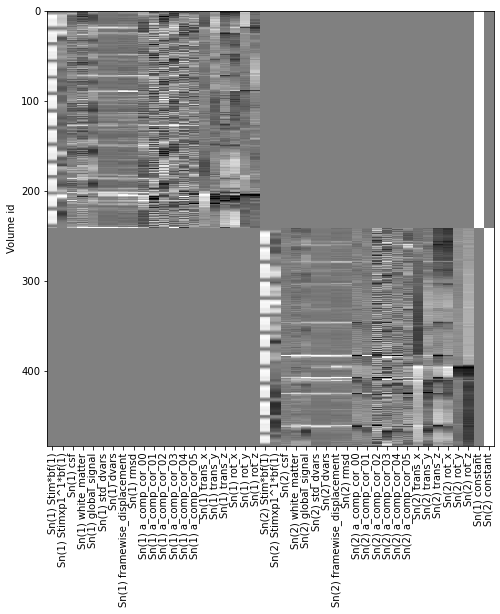

In [139]:
plot_designmat('/output/prob_pmod/1stLevel/sub-29/SPM.mat')

In [140]:
spmmat = load_spmmat('/output/prob_pmod/1stLevel/sub-29/SPM.mat')

In [141]:
spmmat['SPM'][0][0].xCon[0][0].name[0]

'pprob_p1'

In [142]:
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
names

['Sn(1) Stim*bf(1)',
 'Sn(1) Stimxp1^1*bf(1)',
 'Sn(1) csf',
 'Sn(1) white_matter',
 'Sn(1) global_signal',
 'Sn(1) std_dvars',
 'Sn(1) dvars',
 'Sn(1) framewise_displacement',
 'Sn(1) rmsd',
 'Sn(1) a_comp_cor_00',
 'Sn(1) a_comp_cor_01',
 'Sn(1) a_comp_cor_02',
 'Sn(1) a_comp_cor_03',
 'Sn(1) a_comp_cor_04',
 'Sn(1) a_comp_cor_05',
 'Sn(1) trans_x',
 'Sn(1) trans_y',
 'Sn(1) trans_z',
 'Sn(1) rot_x',
 'Sn(1) rot_y',
 'Sn(1) rot_z',
 'Sn(2) Stim*bf(1)',
 'Sn(2) Stimxp1^1*bf(1)',
 'Sn(2) csf',
 'Sn(2) white_matter',
 'Sn(2) global_signal',
 'Sn(2) std_dvars',
 'Sn(2) dvars',
 'Sn(2) framewise_displacement',
 'Sn(2) rmsd',
 'Sn(2) a_comp_cor_00',
 'Sn(2) a_comp_cor_01',
 'Sn(2) a_comp_cor_02',
 'Sn(2) a_comp_cor_03',
 'Sn(2) a_comp_cor_04',
 'Sn(2) a_comp_cor_05',
 'Sn(2) trans_x',
 'Sn(2) trans_y',
 'Sn(2) trans_z',
 'Sn(2) rot_x',
 'Sn(2) rot_y',
 'Sn(2) rot_z',
 'Sn(1) constant',
 'Sn(2) constant']

In [143]:
cons = [i[0] for i in spmmat['SPM'][0][0].xCon[0][0].c]
np.nonzero(cons)

(array([ 1, 22]),)

In [144]:
len(cons)

44

### check 1st level contrast

In [145]:
con = '/output/prob_pmod/1stLevel/sub-29/spmT_0001.nii'

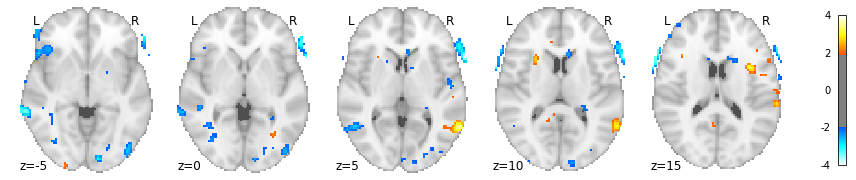

In [146]:
nilearn.plotting.plot_stat_map(con, threshold=2, display_mode='z', 
                               cut_coords=(-5,0,5,10,15))

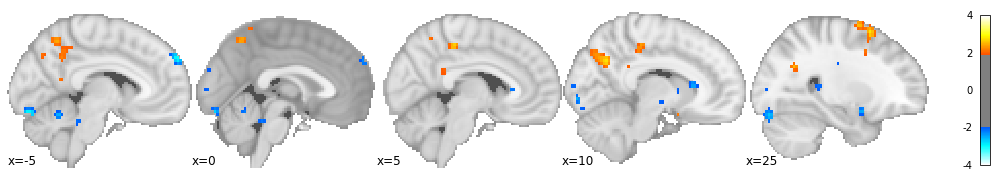

In [147]:
nilearn.plotting.plot_stat_map(con, threshold=2, display_mode='x', 
                               cut_coords=(-5,0,5,10,25))

In [148]:
con = '/output/prob_pmod/1stLevel/sub-29/spmT_0002.nii'

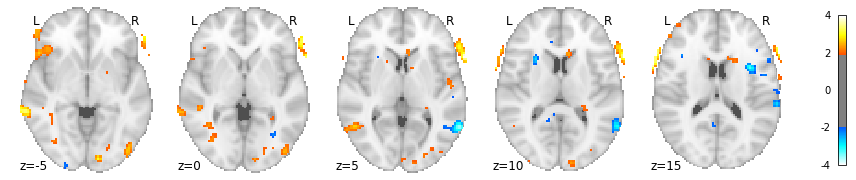

In [149]:
nilearn.plotting.plot_stat_map(con, threshold=2, display_mode='z', 
                               cut_coords=(-5,0,5,10,15))

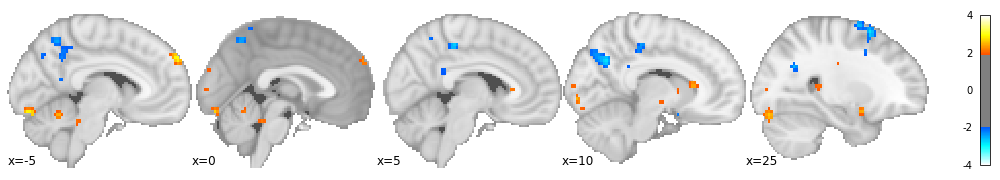

In [150]:
nilearn.plotting.plot_stat_map(con, threshold=2, display_mode='x', 
                               cut_coords=(-5,0,5,10,25))

### 2nd level

In [158]:
# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002']
mask = '/data/group_mask.nii.gz'

### 2nd level nodes

In [159]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

### 2nd level IO

In [160]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list)]
#                         ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(experiment_dir, output_dir, '1stLevel', 'sub-*',
                         '{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
datasink.inputs.substitutions = substitutions

### 2nd level workflow

In [161]:
# unmasked preproc and 1st level, using mask in 2nd level
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

### run 2nd level

In [162]:
bl2analysis.run('MultiProc', plugin_args={'n_procs': 4})

201018-11:50:30,561 nipype.workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
201018-11:50:30,951 nipype.workflow INFO:
	 Running in parallel.
201018-11:50:31,38 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201018-11:50:31,654 nipype.workflow INFO:
	 [Job 2] Cached (spm_l2analysis.gunzip).
201018-11:50:31,657 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0001/selectfiles".
201018-11:50:31,643 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0002/selectfiles".
201018-11:50:31,698 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
201018-11:50:31,711 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.selectfiles".
201018-11:50:31,718 nipype.workflow INFO:
	 [Node] R

201018-11:51:21,68 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
201018-11:51:21,75 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".201018-11:51:21,77 nipype.workflow INFO:
	 [Job 11] Completed (spm_l2analysis.level2thresh).
201018-11:51:21,80 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.87/14.07, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.level2thresh

201018-11:51:21,483 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
201018-11:51:21,489 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0001/datasink".
201018-11:51:21,494 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
201018-11:51:21,505 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201018-11:51:21,511 ni

### check 2nd level output

In [192]:
# con = '/output/prob_pmod/2ndLevel/con_0001/spmT_0001_thr.nii'
con = '/output/prob_pmod/2ndLevel/con_0001/spmT_0001.nii'

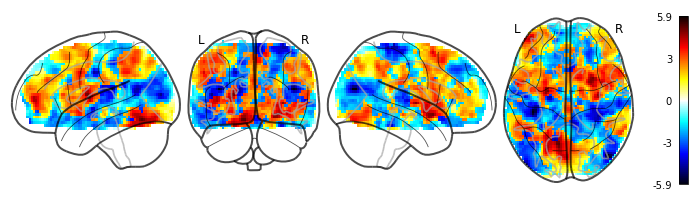

In [193]:
nilearn.plotting.plot_glass_brain(con, display_mode='lyrz', colorbar=True, plot_abs=False)

In [184]:
# con = '/output/prob_pmod/2ndLevel/con_0001/spmT_0001_thr.nii'
con = '/output/prob_pmod/2ndLevel/con_0001/spmT_0001.nii'

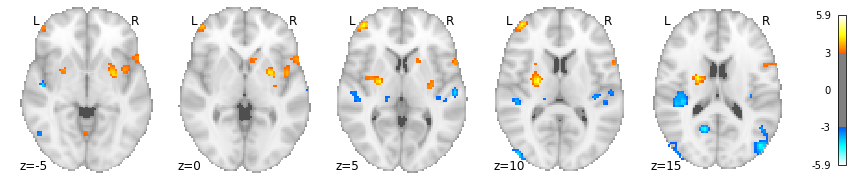

In [185]:
pmod_z = nilearn.plotting.plot_stat_map(con, threshold=3, display_mode='z', 
                               cut_coords=(-5,0,5,10,15))
pmod_z.savefig('./figs/pmod_z.pdf')

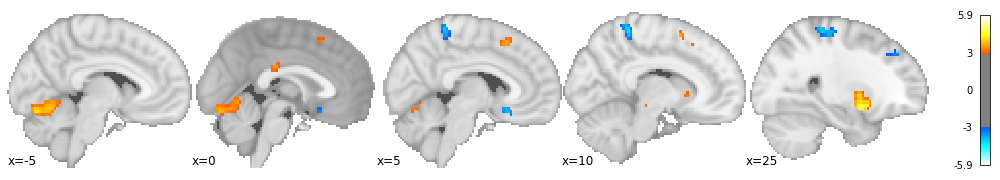

In [186]:
pmod_x = nilearn.plotting.plot_stat_map(con, threshold=3, display_mode='x', 
                               cut_coords=(-5,0,5,10,25))
pmod_x.savefig('./figs/pmod_x.pdf')

In [187]:
# con = '/output/prob_pmod/2ndLevel/con_0001/spmT_0001_thr.nii'
con = '/output/prob_pmod/2ndLevel/con_0002/spmT_0001.nii'

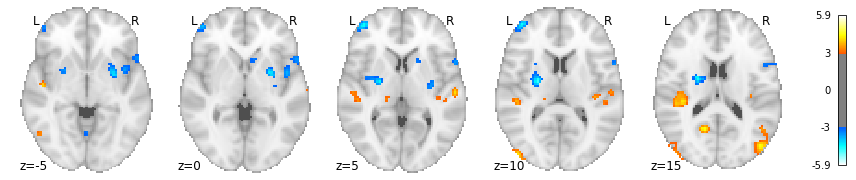

In [188]:
nilearn.plotting.plot_stat_map(con, threshold=3, display_mode='z', 
                               cut_coords=(-5,0,5,10,15))

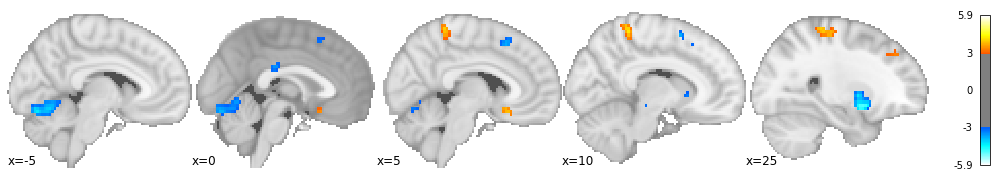

In [189]:
nilearn.plotting.plot_stat_map(con, threshold=3, display_mode='x', 
                               cut_coords=(-5,0,5,10,25))